In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Train Data Loading

In [ ]:
train_data = pd.read_excel('../Data/train_data_prob_added.xlsx')
train_data = train_data.convert_dtypes()
test_data = pd.read_excel('../Data/test_data_prob_added.xlsx')
test_data = test_data.convert_dtypes()

In [3]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              36168 non-null  string 
 1   age            36168 non-null  Int64  
 2   balance        36168 non-null  Int64  
 3   day_of_month   36168 non-null  Int64  
 4   duration       36168 non-null  Int64  
 5   campaign       36168 non-null  Int64  
 6   pdays          36168 non-null  Int64  
 7   previous       36168 non-null  Int64  
 8   NB_prob        36168 non-null  Float64
 9   Logistic_prob  36168 non-null  Float64
 10  DT_prob        36168 non-null  Float64
 11  EBM_prob       36168 non-null  Float64
dtypes: Float64(4), Int64(7), string(1)
memory usage: 3.7 MB
None


In [4]:
display(train_data.head())
train_data.shape

,y,age,balance,day_of_month,duration,campaign,pdays,previous,NB_prob,Logistic_prob,DT_prob,EBM_prob
0,yes,66,2048,27,212,1,-1,0,0.2548,0.590641,0.525657,0.336438
1,no,49,181,8,161,3,-1,0,0.012788,0.184176,0.286525,0.185477
2,no,41,-129,18,176,1,-1,0,0.020337,0.460129,0.403237,0.365158
3,no,42,1316,5,285,1,-1,0,0.070662,0.283496,0.286525,0.372153
4,no,45,1621,18,122,8,-1,0,0.095399,0.416171,0.525657,0.487318


(36168, 12)

## Continuous Covariates

In [5]:
numeric_cols = ["age","balance","campaign","pdays","previous","NB_prob","Logistic_prob","DT_prob","EBM_prob"]
X_train = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()
y_train = (train_data['y'] == "yes").astype(int)
y_test = (test_data['y'] == "yes").astype(int)

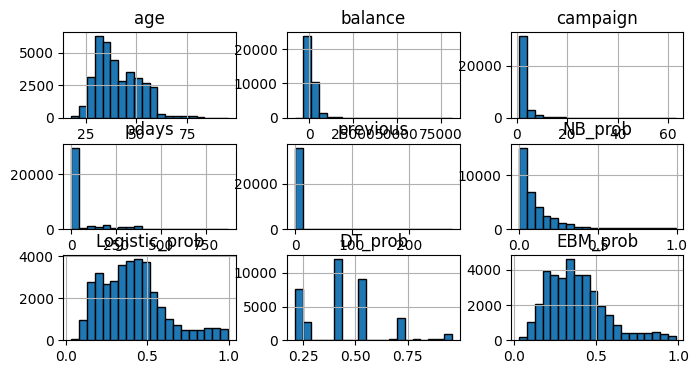

In [6]:
X_train.hist(bins = 20,edgecolor ='black',figsize=(8,4))
plt.show()

In [7]:
X_train["log_balance"] = np.log1p(X_train["balance"]+10000)
X_train["log_previous"] = np.log1p(X_train["previous"]+10000)
X_test["log_balance"] = np.log1p(X_test["balance"]+10000)
X_test["log_previous"] = np.log1p(X_test["previous"]+10000)

In [8]:
X_train.head()

,age,balance,campaign,pdays,previous,NB_prob,Logistic_prob,DT_prob,EBM_prob,log_balance,log_previous
0,66,2048,1,-1,0,0.2548,0.590641,0.525657,0.336438,9.396737,9.21044
1,49,181,3,-1,0,0.012788,0.184176,0.286525,0.185477,9.228377,9.21044
2,41,-129,1,-1,0,0.020337,0.460129,0.403237,0.365158,9.197458,9.21044
3,42,1316,1,-1,0,0.070662,0.283496,0.286525,0.372153,9.334061,9.21044
4,45,1621,8,-1,0,0.095399,0.416171,0.525657,0.487318,9.360655,9.21044


In [9]:
y_train.value_counts()

y
0    31936
1     4232
Name: count, dtype: int64

In [10]:
X_train = X_train.drop(["balance","previous"], axis=1)
X_test = X_test.drop(["balance","previous"], axis=1)

In [11]:
X_train.columns

Index(['age', 'campaign', 'pdays', 'NB_prob', 'Logistic_prob', 'DT_prob',
       'EBM_prob', 'log_balance', 'log_previous'],
      dtype='object')

In [12]:
# Evaluation helper
def print_metrics(y_true, y_pred, y_prob= None):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))
    if y_prob is not None:
        print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")

In [13]:
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1.0, class_weight="balanced"))
])

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print_metrics(y_test, y_pred)

Confusion Matrix:
 [[6739 1247]
 [ 459  598]]

Classification Report:
               precision    recall  f1-score   support

           0      0.936     0.844     0.888      7986
           1      0.324     0.566     0.412      1057

    accuracy                          0.811      9043
   macro avg      0.630     0.705     0.650      9043
weighted avg      0.865     0.811     0.832      9043



In [14]:
X_train.shape

(36168, 9)

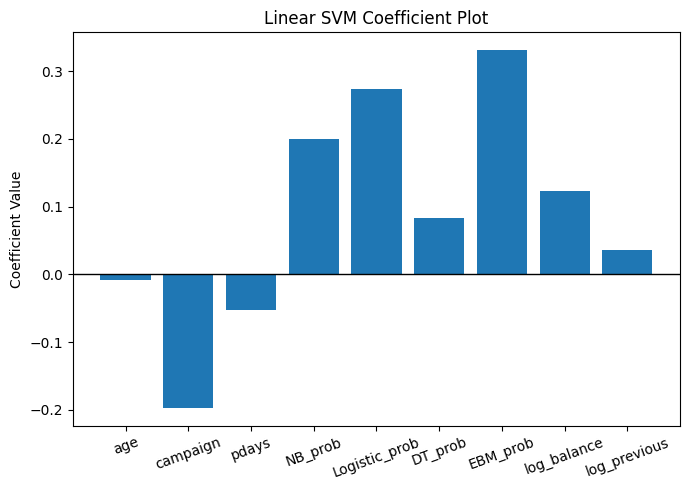

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients
coef = svm_model.named_steps["svc"].coef_[0]

plt.figure(figsize=(7,5))
plt.bar(list(X_train.columns), coef)
plt.axhline(0, color='black', linewidth=1)
plt.title("Linear SVM Coefficient Plot")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [16]:
# Coefficient vector w
w = svm_model.named_steps["svc"].coef_[0]

# Margin width
margin = 2 / np.linalg.norm(w)

print("Margin width:", margin)


Margin width: 3.717938562832163


In [23]:
scaler = svm_model.named_steps["scaler"]
svc     = svm_model.named_steps["svc"]
def plot_decision_boundary(i, j, X, y, model, scaler, h =0.05):
    xi = X[X_train.columns[i]]
    xj = X[X_train.columns[j]]

    x_min, x_max = xi.min()-.1, xi.max()+.1
    y_min, y_max = xj.min()-.1, xj.max()+.1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # ---- FIX: Create dummy full-sized X ----
    X_dummy = pd.DataFrame(
        np.zeros((mesh_points.shape[0], len(X_train.columns))),
        columns=X_train.columns
    )

    # Fill selected columns with mesh
    X_dummy[X_train.columns[i]] = mesh_points[:, 0]
    X_dummy[X_train.columns[j]] = mesh_points[:, 1]

    # Fill remaining columns with their means (or medians)
    for col in X_train.columns:
        if col not in [X_train.columns[i], X_train.columns[j]]:
            X_dummy[col] = X[col].mean()

    mesh_scaled = scaler.transform(X_dummy)  # now correct shape

    Z = model.predict(mesh_scaled).reshape(xx.shape)

    # ---- Plot ----
    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.25)
    plt.scatter(xi, xj, c=y, cmap="coolwarm", s=20, edgecolor='k')

    plt.xlabel(X_train.columns[i])
    plt.ylabel(X_train.columns[j])
    plt.title("SVM Boundary")
    plt.tight_layout()
    plt.show()

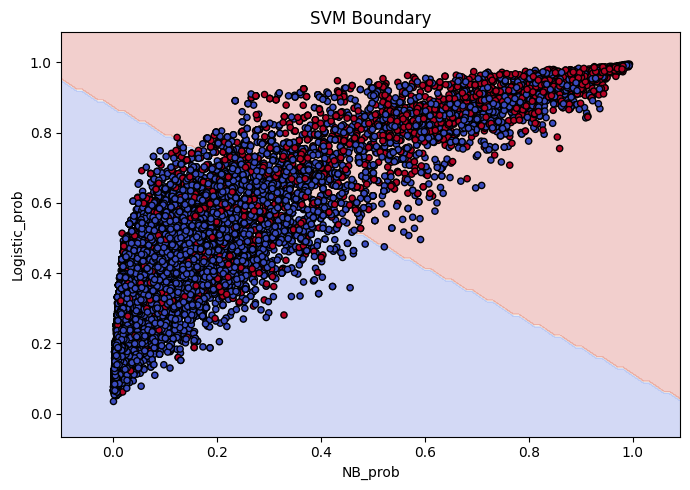

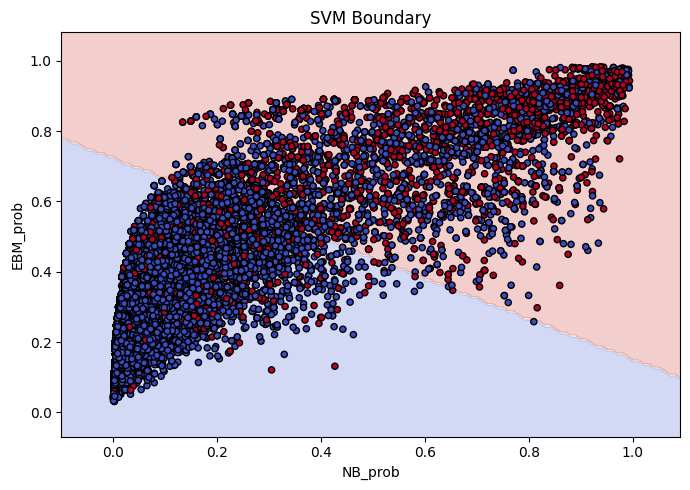

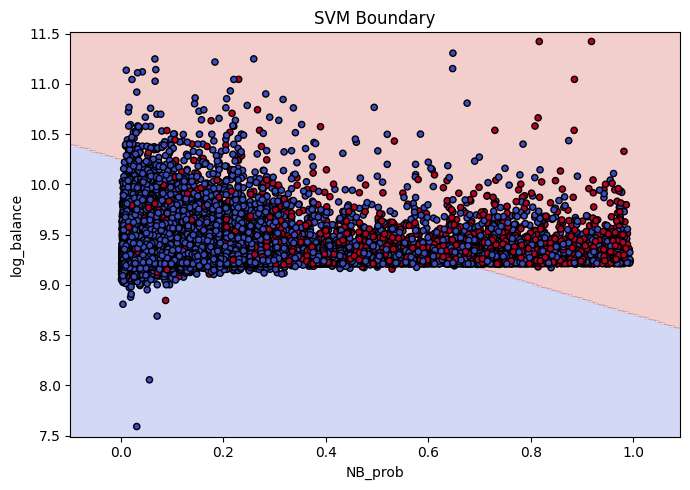

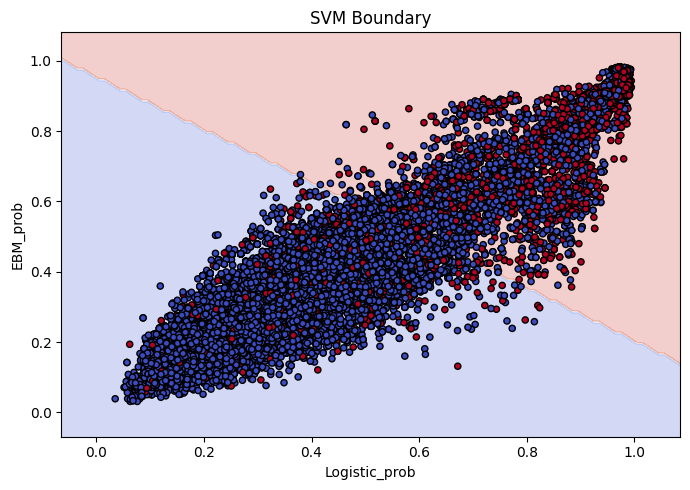

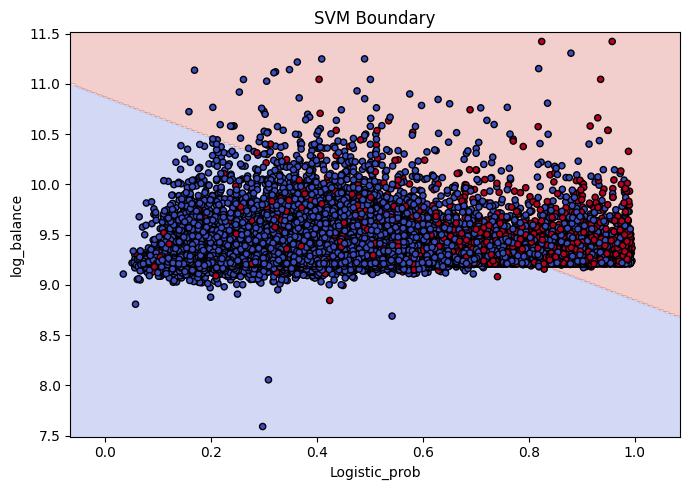

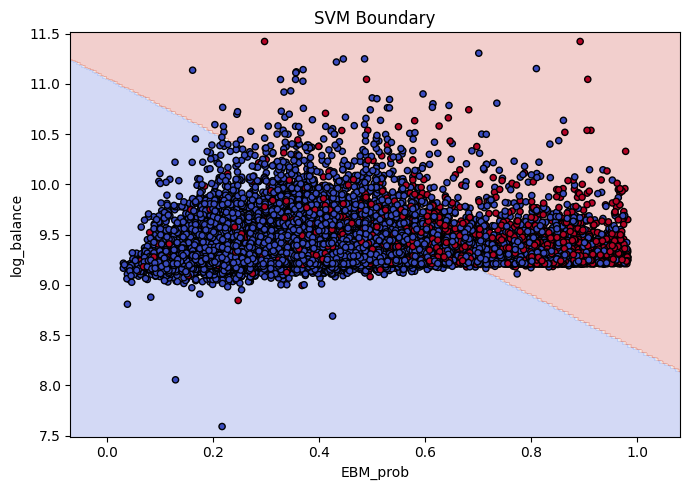

In [24]:
for i in [3,4,6,7]:
    for j in [3,4,6,7]:
        if j>i:
            plot_decision_boundary(i,j,X_train, y_train, svc, scaler, h = 0.01)